In [1]:
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set(style='ticks', context='talk')

# distance matrix
import hdbscan
import membrane_mesh
from angular_distance_matrix import angular_distance_matrix

# calculation
import numpy as np
import numpy.typing as npt
from scipy.spatial import distance, transform

# io
import pathlib
import re
import starfile
import mrcfile

# for dev stuff
import importlib

Please install cupy>=7.0.0b4:
pip install cupy>=7.0.0b4


# Support functions

In [2]:
def vector2axis(xyz: npt.NDArray[float]) -> npt.NDArray[float]:
    """Transforms unit vectors to spherical coordinates.
    
    Parameters
    ----------
    xyz: npt.NDArray[float]
        Unit vectors in a numpy array of shape (N, 3).
    
    Returns
    -------
    npt.NDArray[float]
        Spherical coordinates (in radians) on unit sphere in array of shape (N, 2).
    """
    theta = np.arctan2(np.sqrt(xyz[:, 0] ** 2 + xyz[:, 1] ** 2), xyz[:,2]) # for elevation angle defined from Z-axis down
    phi = np.arctan2(xyz[:,1], xyz[:,0])
    return np.hstack([theta[:, np.newaxis], phi[:, np.newaxis]])


def axis2vector(thetaphi: npt.NDArray[float]) -> npt.NDArray[float]:
    """Transforms spherical coordinates on a unit sphere to unit vectors.
    
    Parameters
    ----------
    thetaphi: npt.NDArray[float]
        Spherical coordinates (in radians) on unit sphere in array of shape (N, 2).
    
    Returns
    -------
    npt.NDArray[float]
        Unit vectors in a numpy array of shape (N, 3).
    """
    x = np.sin(thetaphi[:, 0]) * np.cos(thetaphi[:, 1])
    y = np.sin(thetaphi[:, 0]) * np.sin(thetaphi[:, 1])
    z = np.cos(thetaphi[:, 0])
    return np.hstack([x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis]])


def average_rotations(rotations: npt.NDArray[float]) -> npt.NDArray[float]:
    """Get the mean rotation of a set of ZXZ rotations
    
    Parameters
    ----------
    rotations: npt.NDArray[float]
        ZXZ rotations (in degrees) in array of shape (N, 3)
    
    Returns
    -------
    npt.NDArray[float]
        Average ZXZ rotation (in degrees) of the input returned as array with shape (3,)
    """
    rot = transform.Rotation.from_euler('ZXZ', rotations, degrees=True)

    # build in mean of rotations and return as zxz
    return rot.mean().as_euler('ZXZ', degrees=True)



def write_arrow_bild(p_arrows, m_arrows, filename, outlier_filter=None):
    if outlier_filter is None:
        outlier_filter = [True] * len(p_arrows)
    with open(filename, 'w') as stream:
        for (arrow, normal), inlier in zip(p_arrows, outlier_filter):
            if inlier:
                stream.write('.color red\n')
                stream.write(f'.arrow {arrow[0]:.2f} {arrow[1]:.2f} {arrow[2]:.2f} '
                             f'{arrow[0] + 15 * normal[0]:.2f} '
                             f'{arrow[1] + 15 * normal[1]:.2f} '
                             f'{arrow[2] + 15 * normal[2]:.2f}\n')
        for (arrow, normal), inlier in zip(m_arrows, outlier_filter):
            if inlier:
                stream.write('.color blue\n')
                stream.write(f'.arrow {arrow[0]:.2f} {arrow[1]:.2f} {arrow[2]:.2f} '
                             f'{arrow[0] + 15 * normal[0]:.2f} '
                             f'{arrow[1] + 15 * normal[1]:.2f} '
                             f'{arrow[2] + 15 * normal[2]:.2f}\n')


def write_split_particle_lists(orientations_per_particle_list, distance_range, angle_outlier_filter,
                               split_lists_angle, voxel_size, output_name):

    for data in orientations_per_particle_list:
        d_filter = np.logical_and(np.array(data['distances']) * voxel_size >= distance_range[0],
                                  np.array(data['distances']) * voxel_size <= distance_range[1])
        o_filter = (np.array(data['stds']) < angle_outlier_filter)

        c_filter = np.logical_and(d_filter, o_filter)
        set_1_filter = np.logical_and(np.array(data['orientations']) <= split_lists_angle, c_filter)  # include cutoff
        set_2_filter = np.logical_and(np.array(data['orientations']) > split_lists_angle, c_filter)  # above without

        # apply filter to particle list and write to correct destination
        set_1, set_2 = ParticleList(), ParticleList()
        for s1, s2, part in zip(set_1_filter, set_2_filter, data['particle_list']):
            if s1:
                set_1.append(part)
            elif s2:
                set_2.append(part)

        print('particles in set1 and set2 after splitting angles: ', len(set_1), len(set_2))

        # output file names
        set_1_file_name = os.path.join(output_name,
                                       os.path.splitext(os.path.split(data['segmentation_file'])[1])[0] + \
                                       f'_<{split_lists_angle}deg.xml')
        set_2_file_name = os.path.join(output_name,
                                       os.path.splitext(os.path.split(data['segmentation_file'])[1])[0] + \
                                       f'_>{split_lists_angle}deg.xml')
        # write the sets
        set_1.toXMLFile(set_1_file_name)
        set_2.toXMLFile(set_2_file_name)


def write_clusters(particle_list, clusters):
    for i in np.unique(clusters):
        if i == -1:  # write a list for each cluster that is not 0
            continue
        else:
            cluster_list = ParticleList()
            for c, p in zip(clusters, particle_list):
                if i == c:
                    cluster_list.append(p)
            cluster_list.toXMLFile(f'particles_c{i}.xml')
            print(f'wrote particles_c{i}.xml with {len(cluster_list)} particles')


# Run on single set

In [3]:
data = '1_Allribos_unfiltered'

# particle data
particle_path = pathlib.Path('2Starfiles').joinpath(data).joinpath(data + '.star')
star_data = starfile.read(particle_path)
input_particles = star_data['particles']

# segmentations
segmentation_path = pathlib.Path('1Segmentations')
input_mrc_files = [m for m in segmentation_path.iterdir() if m.suffix == '.mrc']
input_tomogram_list = [re.search('tomo_\d+', m.stem).group() for m in input_mrc_files]  # extract the tilt series names from the segmentation file

# read cut thresholds
input_cut_offs = [float('.' + re.split('thr', m.stem)[1]) for m in input_mrc_files]


In [3]:
def orientation_analysis(
    particles,
    tomogram_list, 
    mrc_files,
    cut_offs, 
    voxel_size_subtomo, 
    voxel_size_segmentation,
    mesh_detail, 
    template_normal, 
    reference_upside_down, 
    verbose
):

    output_distances_voxels, output_stds, output_zxzs = [], [], []
    
    for tilt_series, mrc_path, cut_off in zip(tomogram_list, mrc_files, cut_offs):
        
        # extract coordinates and rotations for this tilt-series
        tomogram_particles = particles[[tilt_series in x for x in particles.rlnMicrographName]]
        coordinates = (
            tomogram_particles[['rlnCoordinateX', 'rlnCoordinateY', 'rlnCoordinateZ']].to_numpy() 
            * voxel_size_subtomo  # express it in angstrom
            / voxel_size_segmentation  # express it in number of voxels in the tomogram
        )
        rotations = tomogram_particles[['rlnAngleRot', 'rlnAngleTilt', 'rlnAnglePsi']].to_numpy()
    
        # convert rotations to ZXZ
        # rotations = transform.Rotation.from_euler('ZYZ', -1 * rotations, degrees=True).as_euler('ZXZ', degrees=True)
        rotations = -1 * transform.Rotation.from_euler('ZYZ', rotations, degrees=True).as_euler('ZXZ', degrees=True)
    
        # read the segmentation and transpose it because indexing with xyz
        segmentation = np.ascontiguousarray(mrcfile.read(mrc_path).T)
    
        print(f' --> analyzing {coordinates.shape[0]} particles in tomogram {tilt_series}')
    
        # create membrane mesh
        membrane = membrane_mesh.MembraneMesh(segmentation, cutoff=cut_off, mesh_detail=mesh_detail, ref_vector=template_normal,
                                upside_down=reference_upside_down)
    
        d, std, p_arrows, m_arrows, zxz = membrane.find_particle_orientations(coordinates, rotations, verbose=verbose)
        output_distances_voxels += d
        output_stds += std
        output_zxzs += zxz
    
        # membrane_arrow_test += m_arrows
        # write_arrow_bild(p_arrows, m_arrows, os.path.join(output_name, name + '.bild'))
        # membrane.write_to_bild(os.path.join(output_name, name + '_mesh.bild'))

    return np.array(output_distances_voxels), np.array(output_stds), np.array(output_zxzs)


def remove_outliers(distances, stds, zxzs, distance_range, angle_std_cutoff, axis_distance_limit, nbins, voxel_size, output_name):
    
    # total number of particles
    n_pre_filter = zxzs.shape[0]
    
    # find distance cutoff  and angle cutoff if not specified
    distance_range = (distances.mean() - nstd * distances.std(), distances.mean() + nstd * distances.std()) if \
        distance_range is None else distance_range
    angle_std_cutoff = nstd * stds.std() + stds.mean() if angle_std_cutoff is None else angle_std_cutoff
    
    # create an outlier filter based on distance and angular variation
    distance_outlier_filter = np.logical_and(distances >= distance_range[0], distances <= distance_range[1])
    angle_outlier_filter = (stds < angle_std_cutoff)
    outlier_filter = np.logical_and(distance_outlier_filter, angle_outlier_filter)
    
    # get angles separately for plotting
    z1_angles, x_angles, z2_angles = zxzs[outlier_filter, 0], zxzs[outlier_filter, 1], zxzs[outlier_filter, 2]
    
    # output number of particle excluded due to filtering
    n = outlier_filter.sum()
    n_outliers = (outlier_filter == False).sum()
    print(f'Number of outliers {n_outliers} in total of {n_pre_filter} => {n} particles left over after filtering')
    
    # visualize z1 angles to ensure they are randomly distributed
    print('Plot Z1 angles; they should be normally distributed (i.e. a flat line).')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist(z1_angles, bins=20)
    ax.set_xlabel(r'Euler Z1 ($\degree$)')
    ax.set_ylabel('Number of particles')
    plt.tight_layout()
    
    if output_name is not None:
        output_path = output_name.joinpath('Z1angles_distribution.png')
        plt.savefig(output_path, dpi=300, format='png', transparent=True)
        plt.close()
        print(f"wrote {output_path}")
    else:
        plt.show()

    # ==================== plot histogram of distances with cutoffs
    print('Plot the outlier filter based on distance from membrane.')
    fig, ax = plt.subplots(figsize=(5, 5))
    bins, _, _ = ax.hist(distances[distances < axis_distance_limit],
                            bins=nbins, color='black', histtype='stepfilled', alpha=0.5)
    bins, _, _ = ax.hist(distances[distances < axis_distance_limit],
                            bins=nbins, color='black', histtype='step')
    if voxel_size is not None:
        ax.set_xlabel(r'Distance ($\AA$)')
    else:
        ax.set_xlabel('Distance (voxels)')
    ax.set_ylabel('Number of particles')
    ax.vlines(distance_range[0], 0, max(bins), label='cutoff', color='orange', linestyles='dashed', linewidth=3)
    ax.vlines(distance_range[1], 0, max(bins), color='orange', linestyles='dashed', linewidth=3)
    ax.legend()
    
    plt.tight_layout()
    
    if output_name is not None:
        output_path = output_name.joinpath('distances.png')
        plt.savefig(output_path, dpi=300, format='png', transparent=True)
        plt.close()
        print(f"wrote {output_path}")
    else:
        plt.show()

    # ==================== plot histogram of angle stds with cutoffs
    print('Plot the outlier filter based on strong deviations in the membrane surface w.r.t. the particle.')
    fig, ax = plt.subplots(figsize=(5, 5))
    bins, _, _ = ax.hist(stds, bins=nbins, color='black', histtype='stepfilled', alpha=0.5)
    bins, _, _ = ax.hist(stds, bins=nbins, color='black', histtype='step')
    if angle_std_cutoff is not None:
        ax.vlines(angle_std_cutoff, 0, max(bins), label='cutoff', color='orange', linestyles='dashed', linewidth=3)
        ax.legend()
    ax.set_xlabel(r'$\sigma$ ($\degree$)')
    ax.set_ylabel('Number of particles')
    
    # information about number of particles
    textstr = f'N={n_pre_filter}'
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    if output_name is not None:
        output_path = output_name.joinpath('angular_std.png')
        plt.savefig(output_path, dpi=300, format='png', transparent=True)
        plt.close()
        print(f"wrote {output_path}")
    else:
        plt.show()

    # filters euler angles and calculate distances between them
    rot_filtered = zxzs[outlier_filter]
    rot_filtered[:, 0] = 0.  # remove first z rotations as its irrelevant for further analysis

    return rot_filtered

def hdbscan_clustering(rot_filtered, interactive_clustering, output_name, clustering_params_init=None):

    ang_matrix = angular_distance_matrix(rot_filtered)

    if clustering_params_init is None:
        # use dbscan, eps is the distance of points to be considered in the neighbourhood
        min_cluster, min_samples, eps = int(0.067 * ang_matrix.shape[0]), int(0.013 * ang_matrix.shape[0]), 0.
    else:
        min_cluster, min_samples, eps = clustering_params_init
        
    # model = cluster.OPTICS(metric='precomputed', max_eps=0.04, min_cluster_size=0.1, n_jobs=8).fit(ang_matrix)
    model = hdbscan.HDBSCAN(metric='precomputed',
                            min_cluster_size=int(0.067 * ang_matrix.shape[0]),
                            min_samples=int(0.013 * ang_matrix.shape[0]),
                            cluster_selection_epsilon=0.)
    model.fit(ang_matrix.astype(np.float64))
    
    while interactive_clustering:
        min_cluster = int(input('Minimum cluster size: '))
        min_samples = int(input('Minimum samples size: '))
        eps = float(input('Epsilon: '))
        # model = cluster.OPTICS(metric='precomputed', max_eps=eps, min_cluster_size=min_cluster,
        # min_samples=min_samples, n_jobs=8, algorithm='brute')
        model = hdbscan.HDBSCAN(metric='precomputed',
                                min_cluster_size=min_cluster,  # int(0.05 * ang_matrix.shape[0]),
                                min_samples=min_samples,  # int(0.02 * ang_matrix.shape[0]))
                                cluster_selection_epsilon=eps)
        model.fit(ang_matrix.astype(np.float64))
        print(np.unique(model.labels_))
    
        fig, ax = plt.subplots(figsize=(4, 8))
        ax.scatter(rot_filtered[:,1], rot_filtered[:,2], alpha=0.7, s=4, c=model.labels_.astype(float))
        ax.set_xlim(0, 180)
        ax.set_xlabel('euler X')
        ax.set_ylim(0, 360)
        ax.set_ylabel('euler Z2')
        plt.show()
    
        interactive_clustering = int(input('Continue with interactive clustering (0 or 1): '))
        interactive_clustering = True if interactive_clustering == 1 else False
    
    # get cluser average
    cluster_angles_dict = {}
    for cluster in np.unique(model.labels_):
        if cluster != -1:
            cluster_rotation = average_rotations(rot_filtered[model.labels_ == cluster])
            cluster_angles_dict[cluster] = cluster_rotation
    
    # write clustering parameters and average zxz per cluster
    cluster_info_file = output_name.joinpath('clustering-info.txt') if output_name is not None else \
        'clustering-info.txt'
    with open(cluster_info_file, 'w') as fstream:
        fstream.write(f'minimum cluster size = {min_cluster} \n')
        fstream.write(f'minimum samples = {min_samples} \n')
        fstream.write(f'epsilon = {eps} \n')
        for cluster in np.unique(model.labels_):
            if cluster != -1:
                fstream.write(f'cluster {cluster} has average zxz: {cluster_angles_dict[cluster]} \n')
    print(f'wrote {cluster_info_file}')
    
    # write rotated references
    # if reference_particle is not None:
    #     ref = read(reference_particle)
    #     write('c-ref.mrc', ref)
    #     for k, rot in cluster_angles_dict.items():
    #         write(f'c{k}.mrc', vt.transform(ref, rotation=(-rot[2], -rot[1], .0), rotation_order='rzxz'))
    
    # write clusters as particle lists
    # new_list = ParticleList()
    # for i, (f, p) in enumerate(zip(outlier_filter, combined_particle_list)):
    #     new_list.append(p)
    # write_clusters(new_list, model.labels_)

    return model, cluster_angles_dict


def density_plot(x_angles, z2_angles, nbins, output_name):

    # DENSITY PLOT
    fig, ax = plt.subplots(figsize=(4.5, 7))
    h = ax.hist2d(x_angles, z2_angles, bins=(nbins//2, nbins))
    plt.colorbar(h[3], ax=ax)
    ax.set_xlabel(r'Euler X ($\degree$)')
    ax.set_ylabel(r'Euler Z2 ($\degree$)')
    # plt.tight_layout()
    if output_name is not None:
        output_path = output_name.joinpath('2d_rot_density.png')
        plt.savefig(output_path, dpi=300, format='png',
                    bbox_inches='tight')
        plt.close()
        print(f"wrote {output_path}")
    else:
        plt.show()



def scatter_plot(x_angles, z2_angles, model, cluster_angles_dict, output_name):
    
    # SCATTER PLOT
    norm = plt.Normalize(model.labels_.min(), model.labels_.max())
    cmap_name = 'viridis'
    cmap = mpl.cm.ScalarMappable(norm, cmap=cmap_name).get_cmap()
    
    fig, ax = plt.subplots(figsize=(4, 8))
    ax.scatter(x_angles, z2_angles, alpha=0.7, s=4, c=model.labels_.astype(float), norm=norm, cmap=cmap_name)
    ax.scatter([v[1] for v in cluster_angles_dict.values()],
               [v[2] if v[2] >= 0 else v[2] + 360 for v in cluster_angles_dict.values()],
               c=np.array(list(cluster_angles_dict.keys())).astype(float), s=4, norm=norm, cmap=cmap_name)
    
    # plot lines to cluster center
    for theta, psi, c in zip(x_angles, z2_angles, model.labels_):
        if c != -1:
            c_theta, c_psi = cluster_angles_dict[c][1], cluster_angles_dict[c][2]
            c_psi = c_psi if c_psi >= 0 else c_psi + 360
            if abs(psi - c_psi) > 180:
                x = [theta, c_theta]
                y = [psi, c_psi + 360] if psi > c_psi else [psi, c_psi - 360]
                plt.plot(x, y, color=cmap(norm(float(c))), alpha=0.2)
    
                x = [theta, c_theta]
                y = [psi - 360, c_psi] if psi > c_psi else [psi + 360, c_psi]
                plt.plot(x, y, color=cmap(norm(float(c))), alpha=0.2)
            else:
                x = [theta, c_theta]
                y = [psi, c_psi]
                plt.plot(x, y, color=cmap(norm(float(c))), alpha=0.2)
    
    ax.set_xlim(0, 180)
    ax.set_xlabel(r'Euler X ($\degree$)')
    ax.set_ylim(0, 360)
    ax.set_ylabel(r'Euler Z2 ($\degree$)')
    # plt.tight_layout()
    if output_name is not None:
        output_path = output_name.joinpath('2d_rot_scatter.png')
        plt.savefig(output_path, dpi=300, format='png',
                    bbox_inches='tight')
        plt.close()
        print(f"wrote {output_path}")
    else:
        plt.show()


In [7]:
# for development: importlib.reload(membrane_mesh) 

# ========== SET PARAMETERS AS DESIRED =============

param_voxel_size_segmentation = 17.36
param_box_size_segmentation = 464
param_voxel_size_subtomo = 4.34

param_mesh_detail = 2
param_template_normal = [.0, .0, 1.]
param_reference_upside_down = True #ref vector orientation correction

param_verbose = False

# ==================================================



# call function
n = 5   # run only on the first n tomograms
distances_voxels_np, stds_np, zxzs_np = orientation_analysis(
    input_particles,
    input_tomogram_list[:n],   # @lena: remove the '[:n]' in these three lines to run on the whole set!
    input_mrc_files[:n],
    input_cut_offs[:n], 
    param_voxel_size_subtomo, 
    param_voxel_size_segmentation,
    param_mesh_detail, 
    param_template_normal, 
    param_reference_upside_down, 
    param_verbose
)


 --> analyzing 126 particles in tomogram tomo_039
 --> analyzing 44 particles in tomogram tomo_033
 --> analyzing 189 particles in tomogram tomo_055
 --> analyzing 66 particles in tomogram tomo_079
 --> analyzing 78 particles in tomogram tomo_089


Number of outliers 375 in total of 503 => 128 particles left over after filtering
Plot Z1 angles; they should be normally distributed (i.e. a flat line).


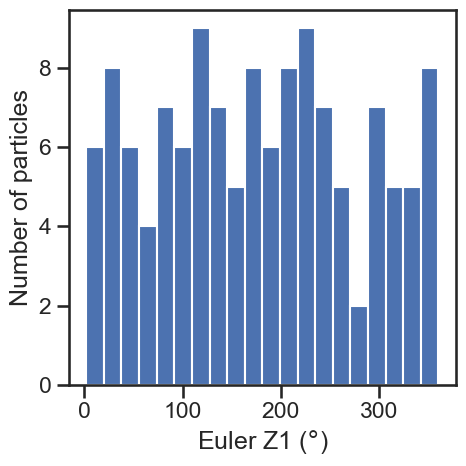

Plot the outlier filter based on distance from membrane.


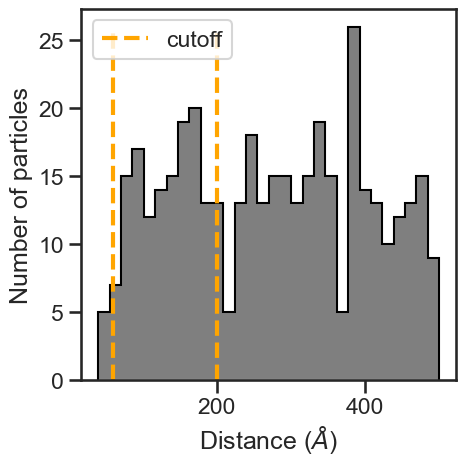

Plot the outlier filter based on strong deviations in the membrane surface w.r.t. the particle.


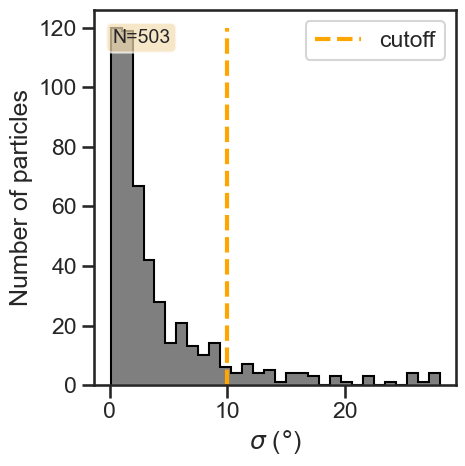

In [8]:
# ============= SET PARAMETERS ============
param_output_name = None  # replace with for writing figures: pathlib.Path('SOME_DIRECTORY')
param_voxel_size = param_voxel_size_segmentation
param_distance_range = (60, 200)  # min and max cut off for distance to membrane in Å
param_axis_distance_limit = 500  # show distance to membrane up to this value in histograms in Å
param_angle_std_cutoff = 10  # cut off for std of angles, max. 10
param_nbins = 30  # number of bins for histogram

# =========================================

# convert distance to angstrom
distances_angstrom = distances_voxels_np * param_voxel_size if param_voxel_size is not None else distances_voxels_np


output_rot_filtered = remove_outliers(
    distances_angstrom, 
    stds_np, 
    zxzs_np,
    param_distance_range,
    param_angle_std_cutoff,
    param_axis_distance_limit,
    param_nbins,
    param_voxel_size,
    param_output_name  #pathlib.Path("3Orientation/6_OMMribos_active")
)


Minimum cluster size:  30
Minimum samples size:  10
Epsilon:  0.01


[-1]


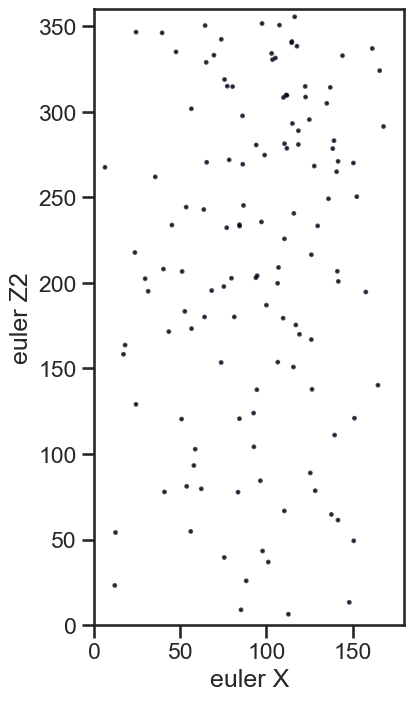

Continue with interactive clustering (0 or 1):  0


wrote clustering-info.txt


In [15]:
#clusters
param_interactive_clustering = True


output_model, output_cluster_angles_dict = hdbscan_clustering(
    output_rot_filtered,
    param_interactive_clustering,
    param_output_name
)


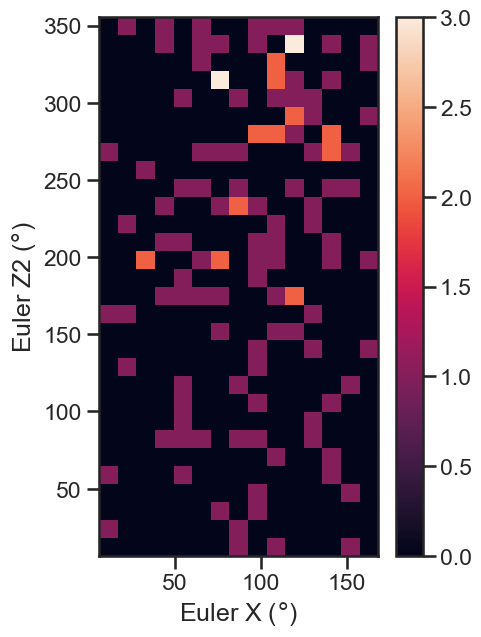

In [13]:
# ============ test angle vs angle
# => scipy.stats.gaussian_kde
# could do a 2d kde on the data and then correct the density for random angular distribution of the vector angle



density_plot(
    output_rot_filtered[:, 1],
    output_rot_filtered[:, 2],
    param_nbins,
    param_output_name
)


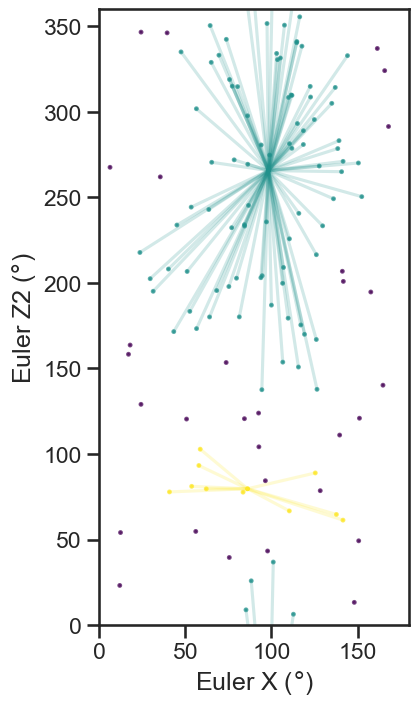

In [14]:


scatter_plot(
    output_rot_filtered[:, 1],
    output_rot_filtered[:, 2],
    output_model,
    output_cluster_angles_dict,
    param_output_name
)

# Run over all particle groupings

In [4]:
# ========== SET ORIENTATION ANALYSIS PARAMETERS =============

param_voxel_size_segmentation = 17.36
param_box_size_segmentation = 464
param_voxel_size_subtomo = 4.34

param_mesh_detail = 2
param_template_normal = [.0, .0, 1.]
param_reference_upside_down = True

param_verbose = False

# ============= SET CLUSTERING AND PLOTTING PARAMETERS ============

param_min_cluster_size = 30
param_min_sample_size = 10
param_epsilon = 0.01
clustering_params_tuple = (param_min_cluster_size, param_min_sample_size, param_epsilon)
param_interactive_clustering = False

param_output_dir = pathlib.Path('./3Orientation')

param_voxel_size = param_voxel_size_segmentation
param_distance_range = (60, 200)  # min and max cut off for distance to membrane
param_axis_distance_limit = 500  # show distance to membrane up to this value in histograms
param_angle_std_cutoff = 10  # cut off for std of angles, max. 10
param_nbins = 30  # number of bins for 2d histogram plot

# =========================================

In [5]:
# segmentations
segmentation_path = pathlib.Path('1Segmentations')
input_mrc_files = [m for m in segmentation_path.iterdir() if m.suffix == '.mrc']
input_tomogram_list = [re.search('tomo_\d+', m.stem).group() for m in input_mrc_files]  # extract the tilt series names from the segmentation file

# read cut thresholds
input_cut_offs = [float('.' + re.split('thr', m.stem)[1]) for m in input_mrc_files]

#create dictionary for distance information
distances_dictionary = dict()


for path in pathlib.Path('2Starfiles').iterdir():

    grouping = path.name

    particle_path = path.joinpath(grouping + '.star')

    param_output_dir_grouping = param_output_dir.joinpath(grouping)

    if not param_output_dir_grouping.exists():
        param_output_dir_grouping.mkdir()

    if not particle_path.exists():
        print(f'Skipping particle grouping {grouping} as starfile could not be found')
        continue
       
    # particle data
    star_data = starfile.read(particle_path)
    input_particles = star_data['particles']

    distances_voxels_np, stds_np, zxzs_np = orientation_analysis(
        input_particles,
        input_tomogram_list[:10], 
        input_mrc_files[:10],
        input_cut_offs[:10], 
        param_voxel_size_subtomo, 
        param_voxel_size_segmentation,
        param_mesh_detail, 
        param_template_normal, 
        param_reference_upside_down, 
        param_verbose
    )

    # convert distance to angstrom
    distances_angstrom = distances_voxels_np * param_voxel_size if param_voxel_size is not None else distances_voxels_np
    distances_dictionary[grouping] = distances_angstrom.copy()
    
    output_rot_filtered = remove_outliers(
        distances_angstrom, 
        stds_np, 
        zxzs_np,
        param_distance_range,
        param_angle_std_cutoff,
        param_axis_distance_limit,
        param_nbins,
        param_voxel_size,
        param_output_dir_grouping
    )
    
    output_model, output_cluster_angles_dict = hdbscan_clustering(
        output_rot_filtered,
        param_interactive_clustering,
        param_output_dir_grouping,
        clustering_params_init=clustering_params_tuple
    )

    density_plot(
        output_rot_filtered[:, 1],
        output_rot_filtered[:, 2],
        param_nbins,
        param_output_dir_grouping
    )

    scatter_plot(
        output_rot_filtered[:, 1],
        output_rot_filtered[:, 2],
        output_model,
        output_cluster_angles_dict,
        param_output_dir_grouping
    )


 --> analyzing 84 particles in tomogram tomo_000
 --> analyzing 84 particles in tomogram tomo_001
 --> analyzing 10 particles in tomogram tomo_002
 --> analyzing 76 particles in tomogram tomo_003
 --> analyzing 31 particles in tomogram tomo_004
 --> analyzing 19 particles in tomogram tomo_005
 --> analyzing 79 particles in tomogram tomo_006
 --> analyzing 27 particles in tomogram tomo_007
 --> analyzing 39 particles in tomogram tomo_008
 --> analyzing 45 particles in tomogram tomo_009
Number of outliers 221 in total of 494 => 273 particles left over after filtering
Plot Z1 angles; they should be normally distributed (i.e. a flat line).
wrote 3Orientation\6_OMMribos_unfiltered_ES27Lin\Z1angles_distribution.png
Plot the outlier filter based on distance from membrane.
wrote 3Orientation\6_OMMribos_unfiltered_ES27Lin\distances.png
Plot the outlier filter based on strong deviations in the membrane surface w.r.t. the particle.
wrote 3Orientation\6_OMMribos_unfiltered_ES27Lin\angular_std.png


In [8]:
print(distances_dictionary.keys())
sns.kdeplot(distances_dictionary['6_OMMribos_unfiltered_ES27Lin'])
sns.kdeplot(distances_dictionary['7_OMMribos_unfiltered_ES27Lexit'])

dict_keys(['6_OMMribos_unfiltered_ES27Lin', '7_OMMribos_unfiltered_ES27Lexit'])


array([ 172.37163757,  165.5939755 ,  275.55455782,  104.40613231,
        240.87333731,  206.31363785,   35.48010891,   70.50739934,
         59.55258366,  406.68046865,  150.67933265,   91.85230106,
        545.24688703,  135.57681823,  183.24208108,  118.39489417,
        951.14310359,  285.06884063,  381.77175372,   82.60745793,
         68.95217538,  112.83383712,  101.64971701,   91.48877484,
         99.68303702,   79.97522101,  452.34167809,  215.9673998 ,
        167.95089363,   39.01023654,   82.97243533,  233.76741596,
        606.53482453,  173.37491125,  229.40775295,  181.02004474,
        258.62208928,  391.26424486,  244.94858068,  527.29576899,
        255.75777896,  496.29370023,  208.09525541,   38.91436509,
        204.02210608,   72.25231081,   73.7765363 ,   52.32564353,
        675.1312971 ,   50.21452061,  379.24266643,  490.64494434,
        232.04143954,  898.55637453,  139.25040781,  283.966495  ,
         52.44928014,  554.52889971,  103.98788021,  119.67288